<a href="https://colab.research.google.com/github/mishratushar/CIFAR10/blob/master/CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import PIL
import matplotlib.pyplot as plt
from math import ceil
import copy

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
Num_Train = 49000

transform = T.Compose([
                T.ColorJitter(hue=.05, saturation=.05),
                T.RandomHorizontalFlip(),
                T.RandomRotation(20, resample=PIL.Image.BILINEAR),
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
            ])

cifar10_train = dset.CIFAR10('./cs231n/datasets', train = True, transform = transform, download = True)
loader_train = DataLoader(cifar10_train, batch_size = 64, sampler = sampler.SubsetRandomSampler(range(Num_Train)))

cifar10_val = dset.CIFAR10('./cs231n/datasets', train=True, download=True, transform=transform)
loader_val = DataLoader(cifar10_val, batch_size = 64, sampler=sampler.SubsetRandomSampler(range(Num_Train, 50000)))

cifar10_test = dset.CIFAR10('./cs231n/datasets', train=False, download=True, transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)


Extracting ./cs231n/datasets/cifar-10-python.tar.gz to ./cs231n/datasets
Files already downloaded and verified
Files already downloaded and verified


In [3]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


print('using device:', device)

using device: cuda


In [30]:
def check(loader, model, verbose=False):
    num_correct = 0
    num_samples = 0
    model = model.to(device=device)
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        i = 0
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            i += 1
            if(i%20 == 0 and not verbose):
                break
        acc = float(num_correct) / num_samples
        if(verbose):
            print('\nGot %d correct out of %d' %(num_correct, num_samples), end = ' ')
        return(acc)

In [5]:
def train(model, optimizer, epochs=1, verbose=False, ep_so_far=0, print_every=1):
    model = model.to(device=device)
    i = 0
    loss_hist, tr_hist, val_hist = [],[],[]
    best_val = 0
    for e in range(epochs):
        for (x,y) in (loader_train):
            model.train()
            x = x.to(device=device, dtype=dtype)
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)
            loss_hist.append(loss.item())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if(e%print_every==0):
          print('epoch : %d loss : %0.4f' %(e+ep_so_far+1, loss.item()), end=' ')
          val_acc, train_acc = check(loader_val, model), check(loader_train, model)
          print('Training Accuracy : %0.2f Validation Accuracy : %0.2f' %(100*train_acc, 100*val_acc), end = '\n\n')
          tr_hist.append(train_acc)
          val_hist.append(val_acc)
        
    if(verbose):
        return loss_hist, tr_hist, val_hist

In [6]:
def train_vis(model, learning_rate, epochs=1, step_decay=1, reg=0, verbose=True, print_every=1, model_name=''):
    n = ceil(epochs/step_decay)
    loss_hist, tr_hist, val_hist = [],[],[]
    for i in range(n):
        lr = learning_rate/(2**i)
        optimizer =  optim.Adam(model.parameters(), lr = lr, weight_decay=reg)
        a, b, c = train(model, optimizer, step_decay, verbose=True, ep_so_far = step_decay*i, print_every=print_every)
        loss_hist += a
        tr_hist += b
        val_hist += c
    if(verbose):   
      x = range(len(loss_hist))
      plt.figure()
      plt.plot(x, loss_hist)
      plt.ylim(0, 2.5)
      plt.xlabel("iterations")
      plt.ylabel("loss")
      plt.show()
      
      plt.figure()
      y = range(len(tr_hist))
      plt.plot(y, tr_hist,'r')
      plt.plot(y, val_hist, 'y')
      z = 0.9*np.ones(len(tr_hist))
      plt.plot(y, z, '-')
      plt.legend(('Training Set', 'Validation set'))
      plt.xlabel("epochs")
      plt.ylabel("Accuracy")
      plt.show()    

      PATH = F"/content/gdrive/My Drive/{model_name}"
      torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            }, PATH)

In [7]:
def flatten(x):
    N = x.shape[0] # read in N, C, H, W
    return x.view(N, -1)

class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)
    

In [8]:
class Resnet(nn.Module):
  def __init__(self, channel, p):
    super(Resnet, self).__init__()
    self.conv1 = nn.Conv2d(channel[0], channel[1], kernel_size=3, stride=1, padding=1)
    self.drop1 = nn.Dropout(p)
    self.norm1 = nn.BatchNorm2d(channel[1])
    self.conv2 = nn.Conv2d(channel[1], channel[2], kernel_size=3, stride=1, padding=1)
    self.drop2 = nn.Dropout(p)
    self.norm2 = nn.BatchNorm2d(channel[2])
    self.conv3 = nn.Conv2d(channel[2], channel[3], kernel_size=3, stride=1, padding=1)
    self.norm3 = nn.BatchNorm2d(channel[3])
    self.conv4 = nn.Conv2d(channel[3], channel[4], kernel_size=3, stride=1, padding=1)
    self.drop4 = nn.Dropout(p)
    self.norm4 = nn.BatchNorm2d(channel[4])
    self.conv5 = nn.Conv2d(channel[4], channel[5], kernel_size=3, stride=1, padding=1)
    self.drop5 = nn.Dropout(p)
    self.norm5 = nn.BatchNorm2d(channel[5])
    self.conv6 = nn.Conv2d(channel[5], channel[6], kernel_size=3, stride=1, padding=1)
    self.norm6 = nn.BatchNorm2d(channel[6])
    self.conv7 = nn.Conv2d(channel[6], channel[7], kernel_size=3, stride=1, padding=1)
    self.drop7 = nn.Dropout(p)
    self.norm7 = nn.BatchNorm2d(channel[7])
    self.conv8 = nn.Conv2d(channel[7], channel[8], kernel_size=3, stride=1, padding=1)
    self.drop8 = nn.Dropout(p)
    self.norm8 = nn.BatchNorm2d(channel[8])
    self.conv9 = nn.Conv2d(channel[8], channel[9], kernel_size=3, stride=1, padding=1)
    self.norm9 = nn.BatchNorm2d(channel[9])
    self.fc1 = nn.Linear(4*4*channel[9], channel[10])
    self.fc2 = nn.Linear(channel[10], channel[11])
    self.fc3 = nn.Linear(channel[11], channel[12])


  def forward(self, x):
    x = self.drop1(self.norm1(F.relu(self.conv1(x))))
    h = self.drop2(self.norm2(F.relu(self.conv2(x))))
    x = F.max_pool2d(self.norm3(F.relu(self.conv3(h) + x)), (2,2))
    x = self.drop4(self.norm4(F.relu(self.conv4(x))))
    h = self.drop5(self.norm5(F.relu(self.conv5(x))))
    x = F.max_pool2d(self.norm6(F.relu(self.conv6(h) + x)), (2,2))
    x = self.drop7(self.norm7(F.relu(self.conv7(x))))
    h = self.drop8(self.norm8(F.relu(self.conv8(x))))
    x = F.max_pool2d(self.norm9(F.relu(self.conv9(h) + x)), (2,2))
    x = flatten(x)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x  = self.fc3(x)

    return x


channel = [3, 32, 32, 32, 64, 64, 64, 128, 128, 128, 256, 256, 10]
net = Resnet(channel, p=0.5)

In [ ]:
learning_rate = 10**(np.random.uniform(-7,-1, 10))
for lr in learning_rate:
  model = copy.deepcopy(net)
  print('Learning Rate :%e' %(lr), end=' ')
  train_vis(model, learning_rate=lr, verbose=False)

Learning Rate :3.268023e-04 epoch : 1 loss : 1.1934 Training Accuracy : 42.03 Validation Accuracy : 42.10

Learning Rate :4.105081e-05 epoch : 1 loss : 1.5970 Training Accuracy : 22.89 Validation Accuracy : 20.10

Learning Rate :6.650909e-02 epoch : 1 loss : 2.3031 Training Accuracy : 10.31 Validation Accuracy : 7.80

Learning Rate :8.337863e-02 epoch : 1 loss : 2.3177 Training Accuracy : 8.44 Validation Accuracy : 10.50

Learning Rate :2.714375e-07 epoch : 1 loss : 2.3344 Training Accuracy : 10.00 Validation Accuracy : 10.60

Learning Rate :5.956636e-04 epoch : 1 loss : 1.2623 Training Accuracy : 48.28 Validation Accuracy : 48.40

Learning Rate :3.976560e-06 epoch : 1 loss : 2.1125 Training Accuracy : 12.27 Validation Accuracy : 9.50

Learning Rate :3.886969e-03 epoch : 1 loss : 1.5010 Training Accuracy : 49.30 Validation Accuracy : 52.20

Learning Rate :2.667633e-03 epoch : 1 loss : 1.2160 Training Accuracy : 55.62 Validation Accuracy : 56.60

Learning Rate :4.284468e-02 epoch : 1 lo

In [ ]:
learning_rate = 10**(np.random.uniform(-3,-2, 10))
for lr in learning_rate:
  model = copy.deepcopy(net)
  print('Learning Rate :%e' %(lr), end=' ')
  train_vis(model, learning_rate=lr, verbose=False)

Learning Rate :7.164462e-03 epoch : 1 loss : 1.3829 Training Accuracy : 45.23 Validation Accuracy : 47.10

Learning Rate :2.186843e-03 epoch : 1 loss : 1.2212 Training Accuracy : 55.00 Validation Accuracy : 53.90

Learning Rate :2.381040e-03 epoch : 1 loss : 1.0476 Training Accuracy : 53.75 Validation Accuracy : 52.60

Learning Rate :3.943790e-03 epoch : 1 loss : 1.4959 Training Accuracy : 50.08 Validation Accuracy : 51.10

Learning Rate :1.190144e-03 epoch : 1 loss : 1.2465 Training Accuracy : 56.02 Validation Accuracy : 57.20

Learning Rate :3.821036e-03 epoch : 1 loss : 1.3355 Training Accuracy : 49.30 Validation Accuracy : 49.20

Learning Rate :3.363205e-03 epoch : 1 loss : 1.2343 Training Accuracy : 53.28 Validation Accuracy : 51.80

Learning Rate :4.504037e-03 epoch : 1 loss : 1.5224 Training Accuracy : 43.36 Validation Accuracy : 47.10

Learning Rate :9.093269e-03 epoch : 1 loss : 1.6145 Training Accuracy : 33.98 Validation Accuracy : 34.90

Learning Rate :1.232912e-03 epoch : 1

In [ ]:
learning_rate = 10**(np.random.uniform(-3.2,-2.5, 10))
for lr in learning_rate:
  model = copy.deepcopy(net)
  print('Learning Rate :%e' %(lr), end=' ')
  train_vis(model, learning_rate=lr, verbose=False)

Learning Rate :2.521965e-03 epoch : 1 loss : 1.1056 Training Accuracy : 55.55 Validation Accuracy : 54.20

Learning Rate :1.275374e-03 epoch : 1 loss : 1.3322 Training Accuracy : 50.47 Validation Accuracy : 50.40

Learning Rate :8.495179e-04 epoch : 1 loss : 1.1691 Training Accuracy : 51.88 Validation Accuracy : 53.30

Learning Rate :9.600087e-04 epoch : 1 loss : 1.5666 Training Accuracy : 51.56 Validation Accuracy : 52.20

Learning Rate :8.201399e-04 epoch : 1 loss : 1.0814 Training Accuracy : 52.19 Validation Accuracy : 53.90

Learning Rate :2.109101e-03 epoch : 1 loss : 1.1539 Training Accuracy : 54.45 Validation Accuracy : 53.70

Learning Rate :6.327252e-04 epoch : 1 loss : 1.0995 Training Accuracy : 47.73 Validation Accuracy : 48.30

Learning Rate :2.221249e-03 epoch : 1 loss : 1.3394 Training Accuracy : 50.39 Validation Accuracy : 49.70

Learning Rate :3.041205e-03 epoch : 1 loss : 1.3692 Training Accuracy : 49.69 Validation Accuracy : 50.80

Learning Rate :2.379810e-03 epoch : 1

In [ ]:
lr = 1.232912e-03
regularization = 10**(np.random.uniform(-7,-1, 10))
for reg in regularization:
  model = copy.deepcopy(net)
  print('Regularization :%e' %(reg), end=' ')
  train_vis(model, learning_rate=lr, reg=reg, verbose=False)

Regularization :1.184231e-05 epoch : 1 loss : 1.2466 Training Accuracy : 51.25 Validation Accuracy : 50.00

Regularization :9.330614e-04 epoch : 1 loss : 1.2113 Training Accuracy : 52.81 Validation Accuracy : 51.70

Regularization :1.425594e-07 epoch : 1 loss : 1.5853 Training Accuracy : 53.36 Validation Accuracy : 55.90

Regularization :2.217985e-05 epoch : 1 loss : 0.9832 Training Accuracy : 51.17 Validation Accuracy : 49.80

Regularization :5.456709e-05 epoch : 1 loss : 1.1187 Training Accuracy : 55.23 Validation Accuracy : 56.70

Regularization :5.594962e-04 epoch : 1 loss : 1.0682 Training Accuracy : 48.20 Validation Accuracy : 47.90

Regularization :2.052949e-03 epoch : 1 loss : 1.1749 Training Accuracy : 54.77 Validation Accuracy : 55.80

Regularization :2.215861e-05 epoch : 1 loss : 1.2436 Training Accuracy : 54.30 Validation Accuracy : 53.50

Regularization :3.787917e-03 epoch : 1 loss : 1.0437 Training Accuracy : 48.98 Validation Accuracy : 46.00

Regularization :1.295699e-02

In [ ]:
dropout_prob = np.random.uniform(0.1, 0.8, 10)
lr = 1.232912e-03
reg = 5.456709e-05
for p in dropout_prob:
  model = Resnet(channel, p)
  print('Dropout Probability :%0.2f' %(p), end=' ')
  train_vis(model, learning_rate=lr, reg=reg, verbose=False)

Dropout Probability :0.64 epoch : 1 loss : 1.5137 Training Accuracy : 39.14 Validation Accuracy : 38.70

Dropout Probability :0.72 epoch : 1 loss : 1.3521 Training Accuracy : 24.92 Validation Accuracy : 26.80

Dropout Probability :0.78 epoch : 1 loss : 1.4881 Training Accuracy : 28.28 Validation Accuracy : 30.60

Dropout Probability :0.27 epoch : 1 loss : 0.7595 Training Accuracy : 61.33 Validation Accuracy : 62.60

Dropout Probability :0.30 epoch : 1 loss : 0.8958 Training Accuracy : 60.86 Validation Accuracy : 61.90

Dropout Probability :0.68 epoch : 1 loss : 1.3268 Training Accuracy : 27.03 Validation Accuracy : 28.10

Dropout Probability :0.42 epoch : 1 loss : 0.8657 Training Accuracy : 58.36 Validation Accuracy : 55.20

Dropout Probability :0.19 epoch : 1 loss : 1.6595 Training Accuracy : 66.02 Validation Accuracy : 63.80

Dropout Probability :0.23 epoch : 1 loss : 1.2220 Training Accuracy : 65.16 Validation Accuracy : 62.80

Dropout Probability :0.15 epoch : 1 loss : 1.4315 Train

epoch : 1 loss : 0.9201 Training Accuracy : 66.64 Validation Accuracy : 65.10

epoch : 2 loss : 0.7558 Training Accuracy : 73.83 Validation Accuracy : 73.70

epoch : 3 loss : 0.8394 Training Accuracy : 76.88 Validation Accuracy : 76.40

epoch : 4 loss : 0.7264 Training Accuracy : 78.75 Validation Accuracy : 77.40

epoch : 5 loss : 0.5821 Training Accuracy : 81.33 Validation Accuracy : 79.60

epoch : 6 loss : 0.2966 Training Accuracy : 81.80 Validation Accuracy : 81.20

epoch : 7 loss : 0.6290 Training Accuracy : 83.67 Validation Accuracy : 80.10

epoch : 8 loss : 0.3481 Training Accuracy : 83.67 Validation Accuracy : 82.20

epoch : 9 loss : 0.5964 Training Accuracy : 87.11 Validation Accuracy : 82.50

epoch : 10 loss : 0.4198 Training Accuracy : 86.72 Validation Accuracy : 84.10

epoch : 11 loss : 0.4605 Training Accuracy : 86.95 Validation Accuracy : 82.70

epoch : 12 loss : 0.5393 Training Accuracy : 85.78 Validation Accuracy : 81.10

epoch : 13 loss : 0.6020 Training Accuracy : 87.8

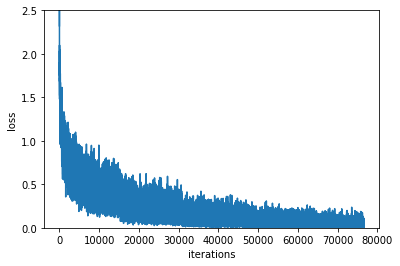

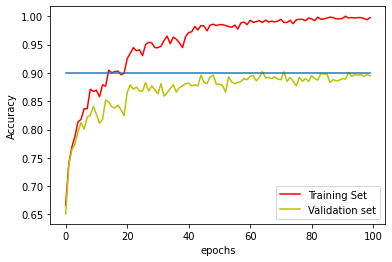

It took  5594.167811155319 seconds


In [ ]:
p = 0.15
import time
model = Resnet(channel, p)
model_name = 'resnet2.pt'
lr = 1.232912e-03
reg = 5.456709e-05
tic = time.time()
train_vis(model, learning_rate=lr, reg=reg, epochs=100, step_decay=20, model_name=model_name)
toc = time.time()
print('It took ', (toc-tic), 'seconds')

epoch : 1 loss : 1.2063 Training Accuracy : 60.47 Validation Accuracy : 56.70

epoch : 2 loss : 0.6575 Training Accuracy : 66.72 Validation Accuracy : 65.50

epoch : 3 loss : 0.9606 Training Accuracy : 71.72 Validation Accuracy : 71.80

epoch : 4 loss : 1.1153 Training Accuracy : 76.56 Validation Accuracy : 74.60

epoch : 5 loss : 1.0128 Training Accuracy : 76.41 Validation Accuracy : 74.80

epoch : 6 loss : 0.8439 Training Accuracy : 79.53 Validation Accuracy : 76.20

epoch : 7 loss : 0.6559 Training Accuracy : 77.97 Validation Accuracy : 77.10

epoch : 8 loss : 0.9501 Training Accuracy : 81.64 Validation Accuracy : 77.80

epoch : 9 loss : 0.5771 Training Accuracy : 82.89 Validation Accuracy : 79.40

epoch : 10 loss : 0.7229 Training Accuracy : 81.25 Validation Accuracy : 79.70

epoch : 11 loss : 0.5566 Training Accuracy : 82.27 Validation Accuracy : 80.10

epoch : 12 loss : 0.4362 Training Accuracy : 81.33 Validation Accuracy : 79.80

epoch : 13 loss : 0.6460 Training Accuracy : 80.9

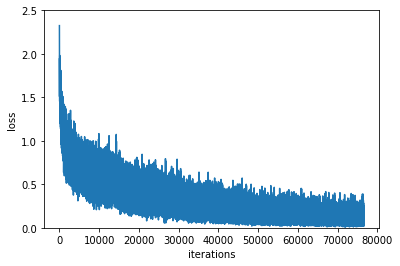

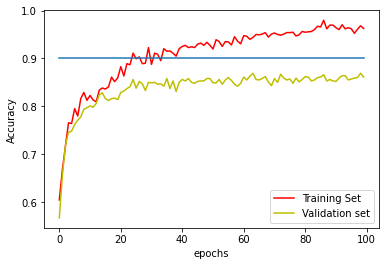

In [ ]:
p = 0.42
model = Resnet(channel, p)
model_name = 'resnet1.pt'
lr = 1.232912e-03
reg = 5.456709e-05
train_vis(model, learning_rate=lr, reg=reg, epochs=100, step_decay=20, model_name=model_name)

epoch : 1 loss : 0.8813 Training Accuracy : 63.67 Validation Accuracy : 62.40

epoch : 2 loss : 0.7760 Training Accuracy : 72.58 Validation Accuracy : 71.20

epoch : 3 loss : 0.8389 Training Accuracy : 75.16 Validation Accuracy : 73.40

epoch : 4 loss : 0.7808 Training Accuracy : 78.20 Validation Accuracy : 76.80

epoch : 5 loss : 0.8224 Training Accuracy : 81.02 Validation Accuracy : 79.50

epoch : 6 loss : 0.6518 Training Accuracy : 82.27 Validation Accuracy : 80.80

epoch : 7 loss : 0.3503 Training Accuracy : 83.36 Validation Accuracy : 81.80

epoch : 8 loss : 0.5463 Training Accuracy : 85.23 Validation Accuracy : 80.90

epoch : 9 loss : 0.5241 Training Accuracy : 84.77 Validation Accuracy : 81.70

epoch : 10 loss : 0.5341 Training Accuracy : 86.56 Validation Accuracy : 82.60

epoch : 11 loss : 0.4999 Training Accuracy : 85.94 Validation Accuracy : 83.20

epoch : 12 loss : 0.4977 Training Accuracy : 87.42 Validation Accuracy : 83.90

epoch : 13 loss : 0.3677 Training Accuracy : 87.7

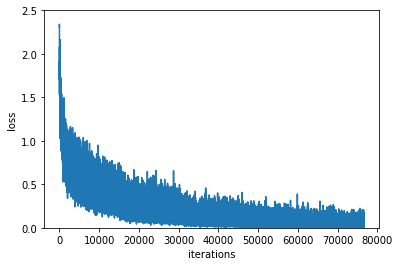

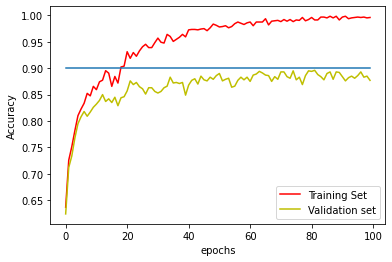

In [ ]:
p = 0.19
model = Resnet(channel, p)
model_name = 'resnet3.pt'
lr = 1.232912e-03
reg = 5.456709e-05
train_vis(model, learning_rate=lr, reg=reg, epochs=100, step_decay=20, model_name=model_name)

In [ ]:
model_name = 'resnet1.pt'
PATH = F"/content/gdrive/My Drive/{model_name}"
checkpoint = (torch.load(PATH))
check1a = copy.deepcopy(checkpoint)
model1a = Resnet(channel, p)
model1a.load_state_dict(check1a['model_state_dict'])
model1a.eval()
print(check(loader_train, model1a, True))
print(check(loader_val, model1a, True))


Got 47178 correct out of 49000 0.9628163265306122

Got 864 correct out of 1000 0.864


In [ ]:
model_name = 'resnet2.pt'
PATH = F"/content/gdrive/My Drive/{model_name}"
checkpoint = (torch.load(PATH))
check1a = copy.deepcopy(checkpoint)
model1a = Resnet(channel, p)
model1a.load_state_dict(check1a['model_state_dict'])
model1a.eval()
print(check(loader_train, model1a, True))
print(check(loader_val, model1a, True))


Got 48878 correct out of 49000 0.9975102040816326

Got 902 correct out of 1000 0.902


In [ ]:
model_name = 'resnet3.pt'
PATH = F"/content/gdrive/My Drive/{model_name}"
checkpoint = (torch.load(PATH))
check1a = copy.deepcopy(checkpoint)
model1a = Resnet(channel, p)
model1a.load_state_dict(check1a['model_state_dict'])
model1a.eval()
print(check(loader_train, model1a, True))
print(check(loader_val, model1a, True))


Got 48820 correct out of 49000 0.9963265306122449

Got 882 correct out of 1000 0.882


epoch : 1 loss : 1.0712 Training Accuracy : 61.95 Validation Accuracy : 61.40

epoch : 2 loss : 0.7671 Training Accuracy : 68.75 Validation Accuracy : 71.30

epoch : 3 loss : 0.5591 Training Accuracy : 74.77 Validation Accuracy : 75.00

epoch : 4 loss : 0.6037 Training Accuracy : 76.72 Validation Accuracy : 73.80

epoch : 5 loss : 0.8155 Training Accuracy : 79.14 Validation Accuracy : 79.60

epoch : 6 loss : 0.6831 Training Accuracy : 79.77 Validation Accuracy : 76.90

epoch : 7 loss : 0.4823 Training Accuracy : 81.64 Validation Accuracy : 80.50

epoch : 8 loss : 0.5170 Training Accuracy : 81.02 Validation Accuracy : 79.50

epoch : 9 loss : 0.7617 Training Accuracy : 83.75 Validation Accuracy : 81.70

epoch : 10 loss : 0.4520 Training Accuracy : 82.11 Validation Accuracy : 79.90

epoch : 11 loss : 0.3425 Training Accuracy : 86.95 Validation Accuracy : 81.90

epoch : 12 loss : 0.4738 Training Accuracy : 85.94 Validation Accuracy : 82.10

epoch : 13 loss : 0.3279 Training Accuracy : 85.9

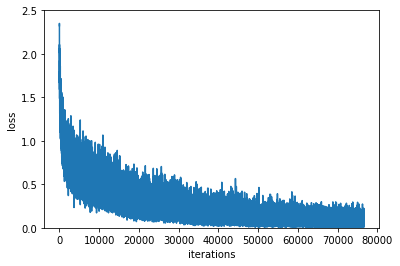

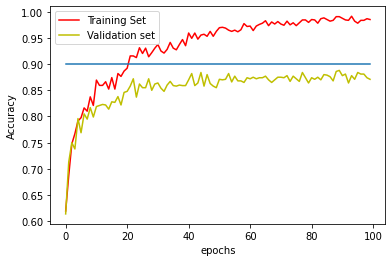

In [ ]:
p = 0.30
model = Resnet(channel, p)
model_name = 'resnet4.pt'
lr = 1.232912e-03
reg = 5.456709e-05
train_vis(model, learning_rate=lr, reg=reg, epochs=100, step_decay=20, model_name=model_name)

In [ ]:
model_name = 'resnet4.pt'
PATH = F"/content/gdrive/My Drive/{model_name}"
checkpoint = (torch.load(PATH))
check1a = copy.deepcopy(checkpoint)
model1a = Resnet(channel, p)
model1a.load_state_dict(check1a['model_state_dict'])
model1a.eval()
print(check(loader_train, model1a, True))
print(check(loader_val, model1a, True))


Got 48365 correct out of 49000 0.9870408163265306

Got 885 correct out of 1000 0.885


epoch : 1 loss : 1.0391 Training Accuracy : 62.34 Validation Accuracy : 63.30

epoch : 2 loss : 1.0454 Training Accuracy : 70.08 Validation Accuracy : 70.10

epoch : 3 loss : 0.7725 Training Accuracy : 77.34 Validation Accuracy : 74.20

epoch : 4 loss : 0.7813 Training Accuracy : 80.16 Validation Accuracy : 77.10

epoch : 5 loss : 0.7224 Training Accuracy : 81.41 Validation Accuracy : 76.70

epoch : 6 loss : 0.7999 Training Accuracy : 82.34 Validation Accuracy : 80.20

epoch : 7 loss : 0.3723 Training Accuracy : 82.27 Validation Accuracy : 80.70

epoch : 8 loss : 0.5985 Training Accuracy : 83.12 Validation Accuracy : 81.70

epoch : 9 loss : 0.5801 Training Accuracy : 86.17 Validation Accuracy : 80.60

epoch : 10 loss : 0.6586 Training Accuracy : 85.70 Validation Accuracy : 82.00

epoch : 11 loss : 0.4261 Training Accuracy : 85.47 Validation Accuracy : 81.30

epoch : 12 loss : 0.4645 Training Accuracy : 86.02 Validation Accuracy : 83.20

epoch : 13 loss : 0.6126 Training Accuracy : 89.4

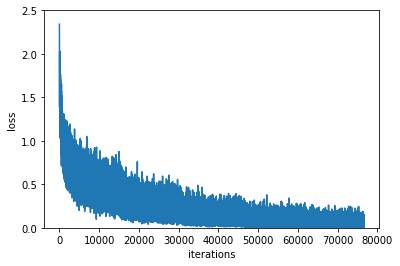

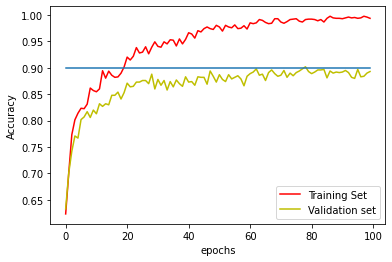

In [9]:
p = 0.23
model = Resnet(channel, p)
model_name = 'resnet5.pt'
lr = 1.232912e-03
reg = 5.456709e-05
train_vis(model, learning_rate=lr, reg=reg, epochs=100, step_decay=20, model_name=model_name)

In [10]:
model_name = 'resnet5.pt'
PATH = F"/content/gdrive/My Drive/{model_name}"
checkpoint = (torch.load(PATH))
check1a = copy.deepcopy(checkpoint)
model1a = Resnet(channel, p)
model1a.load_state_dict(check1a['model_state_dict'])
model1a.eval()
print(check(loader_train, model1a, True))
print(check(loader_val, model1a, True))


Got 48786 correct out of 49000 0.9956326530612245

Got 910 correct out of 1000 0.91


In [47]:
model_name = 'resnet1.pt'
Path = F"/content/gdrive/My Drive/{model_name}"
checkpoint = torch.load(Path)
model1 = Resnet(channel, p)
model1.load_state_dict(checkpoint['model_state_dict'])
model1.eval()
model_name = 'resnet2.pt'
Path = F"/content/gdrive/My Drive/{model_name}"
checkpoint = torch.load(Path)
model2 = Resnet(channel, p)
model2.load_state_dict(checkpoint['model_state_dict'])
model2.eval()
model_name = 'resnet3.pt'
Path = F"/content/gdrive/My Drive/{model_name}"
checkpoint = torch.load(Path)
model3 = Resnet(channel, p)
model3.load_state_dict(checkpoint['model_state_dict'])
model3.eval()
model_name = 'resnet4.pt'
Path = F"/content/gdrive/My Drive/{model_name}"
checkpoint = torch.load(Path)
model4 = Resnet(channel, p)
model4.load_state_dict(checkpoint['model_state_dict'])
model4.eval()
model_name = 'resnet5.pt'
Path = F"/content/gdrive/My Drive/{model_name}"
checkpoint = torch.load(Path)
model5 = Resnet(channel, p)
model5.load_state_dict(checkpoint['model_state_dict'])
model5.eval()

Resnet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop1): Dropout(p=0.23, inplace=False)
  (norm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop2): Dropout(p=0.23, inplace=False)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop4): Dropout(p=0.23, inplace=False)
  (norm4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop5): Dropout(p=0.23, inplace=False)
  (norm5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [48]:
class ensemble(nn.Module):
  def __init__(self, model1, model2, model3, model4, model5):
    super(ensemble, self).__init__()
    self.model1 = model1
    self.model2 = model2
    self.model3 = model3
    self.model4 = model4
    self.model5 = model5

  def forward(self, x):
    scores = (self.model1(x.clone()) + self.model2(x.clone()) + self.model3(x.clone()) + self.model4(x.clone()) + self.model5(x.clone()))/5
    return scores

In [49]:
model = ensemble(model1, model2, model3, model4, model5)
train_acc = check(loader_train, model, True)
print('Training Accuracy :%0.2f' %(100*train_acc))
val_acc = check(loader_val, model, True)
print('Validation Accuracy :%0.2f' %(100*val_acc))


Got 48968 correct out of 49000 Training Accuracy :99.93

Got 911 correct out of 1000 Validation Accuracy :91.10


In [56]:
print('Ensemble Model')
test_acc = check(loader_test, model, True)
print('\nTest Accuracy :%0.2f' %(100*test_acc))
print('\nModel1 ')
test_acc = check(loader_test, model1, True)
print('\nTest Accuracy :%0.2f' %(100*test_acc))
print('\nModel2')
test_acc = check(loader_test, model2, True)
print('\nTest Accuracy :%0.2f' %(100*test_acc))
print('\nModel3')
test_acc = check(loader_test, model3, True)
print('\nTest Accuracy :%0.2f' %(100*test_acc))
print('\nModel4')
test_acc = check(loader_test, model4, True)
print('\nTest Accuracy :%0.2f' %(100*test_acc))
print('\nModel5')
test_acc = check(loader_test, model5, True)
print('\nTest Accuracy :%0.2f' %(100*test_acc))

Ensemble Model

Got 9024 correct out of 10000 
Test Accuracy :90.24

Model1 

Got 8557 correct out of 10000 
Test Accuracy :85.57

Model2

Got 8855 correct out of 10000 
Test Accuracy :88.55

Model3

Got 8799 correct out of 10000 
Test Accuracy :87.99

Model4

Got 8740 correct out of 10000 
Test Accuracy :87.40

Model5

Got 8820 correct out of 10000 
Test Accuracy :88.20


In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

p = 0.3
lr = 2e-3

model = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Linear(4*4*channel6, 256), nn.ReLU(),nn.Linear(256,10))


In [ ]:
regularization = 10**np.random.uniform(-6,-1,10)
for reg in regularization:
  model1 = copy.deepcopy(model)
  print('Regularization strength : %e' %(reg), end=' ')
  train_vis(model1, learning_rate = lr, epochs = 3, reg=reg, verbose=False, print_every=10)

Regularization strength : 6.283232e-04 epoch : 1 loss : 0.7721 Training Accuracy : 67.19 Validation Accuracy : 68.10

epoch : 2 loss : 0.9153 Training Accuracy : 72.97 Validation Accuracy : 72.20

epoch : 3 loss : 0.6854 Training Accuracy : 75.86 Validation Accuracy : 74.00

Regularization strength : 4.273319e-03 epoch : 1 loss : 1.0315 Training Accuracy : 68.67 Validation Accuracy : 68.40

epoch : 2 loss : 0.7015 Training Accuracy : 71.25 Validation Accuracy : 70.30

epoch : 3 loss : 0.8434 Training Accuracy : 74.84 Validation Accuracy : 71.10

Regularization strength : 1.006327e-02 epoch : 1 loss : 1.1699 Training Accuracy : 64.45 Validation Accuracy : 64.20

epoch : 2 loss : 0.8435 Training Accuracy : 67.19 Validation Accuracy : 68.00

epoch : 3 loss : 0.9689 Training Accuracy : 70.16 Validation Accuracy : 72.10

Regularization strength : 1.729448e-05 epoch : 1 loss : 0.6201 Training Accuracy : 69.92 Validation Accuracy : 70.60

epoch : 2 loss : 0.7873 Training Accuracy : 74.84 Vali

epoch : 1 loss : 1.2471 Training Accuracy : 52.27 Validation Accuracy : 53.80

epoch : 2 loss : 1.1526 Training Accuracy : 59.30 Validation Accuracy : 58.30

epoch : 3 loss : 0.8073 Training Accuracy : 64.92 Validation Accuracy : 66.80

epoch : 4 loss : 0.8359 Training Accuracy : 72.58 Validation Accuracy : 71.00

epoch : 5 loss : 0.7069 Training Accuracy : 71.17 Validation Accuracy : 71.70

epoch : 6 loss : 0.8069 Training Accuracy : 73.52 Validation Accuracy : 75.00

epoch : 7 loss : 0.7189 Training Accuracy : 76.56 Validation Accuracy : 74.60

epoch : 8 loss : 0.6654 Training Accuracy : 78.98 Validation Accuracy : 76.90

epoch : 9 loss : 0.6721 Training Accuracy : 79.30 Validation Accuracy : 78.00

epoch : 10 loss : 0.5898 Training Accuracy : 77.97 Validation Accuracy : 78.70

epoch : 11 loss : 0.6904 Training Accuracy : 80.55 Validation Accuracy : 78.70

epoch : 12 loss : 0.3835 Training Accuracy : 80.23 Validation Accuracy : 77.50

epoch : 13 loss : 0.5904 Training Accuracy : 82.6

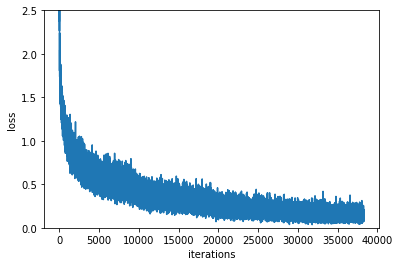

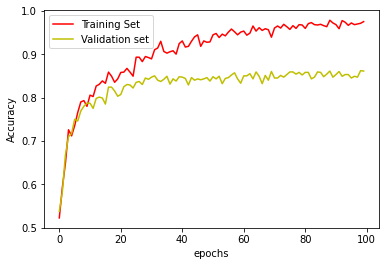

In [ ]:
lr=2e-3
reg=1.155678e-06
# reg=1.956150e-03
train_vis(model, learning_rate=lr, epochs=100, step_decay=25, reg=reg)

epoch : 1 loss : 0.1281 Training Accuracy : 97.19 Validation Accuracy : 85.50

epoch : 2 loss : 0.1537 Training Accuracy : 96.56 Validation Accuracy : 84.50

epoch : 3 loss : 0.1356 Training Accuracy : 98.05 Validation Accuracy : 84.20

epoch : 4 loss : 0.0783 Training Accuracy : 97.42 Validation Accuracy : 86.30

epoch : 5 loss : 0.0645 Training Accuracy : 98.20 Validation Accuracy : 86.30

epoch : 6 loss : 0.1621 Training Accuracy : 97.89 Validation Accuracy : 85.20

epoch : 7 loss : 0.0500 Training Accuracy : 97.89 Validation Accuracy : 85.70

epoch : 8 loss : 0.2304 Training Accuracy : 97.11 Validation Accuracy : 84.10

epoch : 9 loss : 0.1327 Training Accuracy : 97.19 Validation Accuracy : 85.90

epoch : 10 loss : 0.1392 Training Accuracy : 97.42 Validation Accuracy : 86.50

epoch : 11 loss : 0.1529 Training Accuracy : 97.81 Validation Accuracy : 85.70

epoch : 12 loss : 0.1175 Training Accuracy : 97.03 Validation Accuracy : 84.70

epoch : 13 loss : 0.1435 Training Accuracy : 97.5

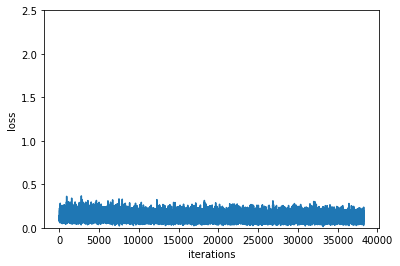

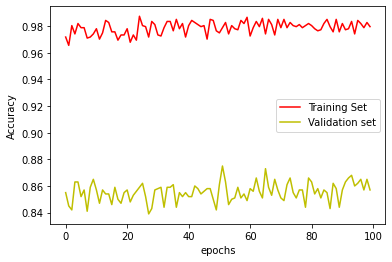

In [ ]:
model1 = copy.deepcopy(model)
train_vis(model, learning_rate = lr/16, epochs=100, reg=4e-5, step_decay=20)

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

p = 0.2
lr = 2e-3
reg = 1.729448e-05


model_a = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Linear(4*4*channel6, 256), nn.ReLU(),nn.Linear(256,10))

train_vis(model_a, learning_rate=lr, epochs=200, step_decay=25, reg=reg)

epoch : 1 loss : 1.3427 Training Accuracy : 56.41 Validation Accuracy : 59.00

epoch : 2 loss : 1.1791 Training Accuracy : 63.98 Validation Accuracy : 65.00

epoch : 3 loss : 0.8437 Training Accuracy : 70.94 Validation Accuracy : 69.60

epoch : 4 loss : 0.9656 Training Accuracy : 72.73 Validation Accuracy : 73.50

epoch : 5 loss : 0.7594 Training Accuracy : 77.81 Validation Accuracy : 76.80

epoch : 6 loss : 0.7502 Training Accuracy : 77.11 Validation Accuracy : 76.90

epoch : 7 loss : 0.6798 Training Accuracy : 79.69 Validation Accuracy : 75.60

epoch : 8 loss : 0.6260 Training Accuracy : 77.89 Validation Accuracy : 76.90

epoch : 9 loss : 0.6731 Training Accuracy : 78.83 Validation Accuracy : 78.70

epoch : 10 loss : 0.4619 Training Accuracy : 81.02 Validation Accuracy : 79.30

epoch : 11 loss : 0.8295 Training Accuracy : 82.50 Validation Accuracy : 78.90

epoch : 12 loss : 0.6994 Training Accuracy : 80.78 Validation Accuracy : 79.30

epoch : 13 loss : 0.6620 Training Accuracy : 81.6

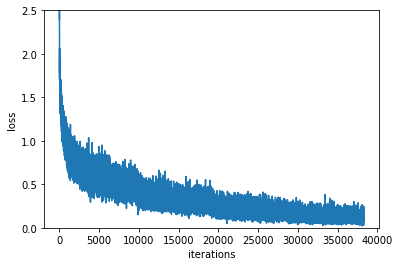

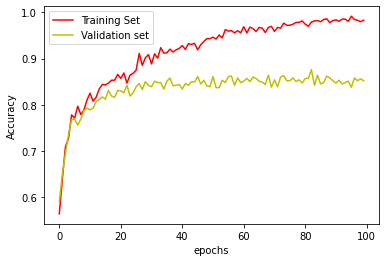

In [ ]:
ychannel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128


p1 = 0.2
p2 = 0.3
p3 = 0.4
lr = 2e-3
reg = 4e-05


model_b = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p1),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p2),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p2),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Linear(4*4*channel6, 256), nn.ReLU(),nn.Linear(256,10))

train_vis(model_b, learning_rate=lr, epochs=100, step_decay=25, reg=reg)

In [ ]:
model_z = copy.deepcopy(model_b)
train_vis(model_z, learning_rate=1e-5, epochs=100, step_decay=25, reg=1000*reg)

epoch : 1 loss : 0.0927 Training Accuracy : 98.59 Validation Accuracy : 86.50

epoch : 2 loss : 0.1122 Training Accuracy : 97.66 Validation Accuracy : 84.40

epoch : 3 loss : 0.0952 Training Accuracy : 98.67 Validation Accuracy : 85.20

epoch : 4 loss : 0.1198 Training Accuracy : 99.06 Validation Accuracy : 85.70

epoch : 5 loss : 0.1132 Training Accuracy : 98.83 Validation Accuracy : 86.30

epoch : 6 loss : 0.1337 Training Accuracy : 98.52 Validation Accuracy : 86.40

epoch : 7 loss : 0.0624 Training Accuracy : 98.52 Validation Accuracy : 85.70

epoch : 8 loss : 0.1312 Training Accuracy : 98.75 Validation Accuracy : 85.90



In [ ]:
 channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

p = 0.3
lr = 2e-3
reg = 1e-4


model_c = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Linear(4*4*channel6, 256), nn.ReLU(),nn.Linear(256,10))

train_vis(model_c, learning_rate=lr, epochs=200, step_decay=25, reg=reg)

epoch : 1 loss : 1.1655 Training Accuracy : 50.94 Validation Accuracy : 49.60

epoch : 2 loss : 1.1715 Training Accuracy : 61.25 Validation Accuracy : 63.60

epoch : 3 loss : 1.0327 Training Accuracy : 64.14 Validation Accuracy : 64.60

epoch : 4 loss : 1.0572 Training Accuracy : 69.38 Validation Accuracy : 71.00

epoch : 5 loss : 0.5745 Training Accuracy : 71.80 Validation Accuracy : 70.40

epoch : 6 loss : 0.9390 Training Accuracy : 75.78 Validation Accuracy : 73.60

epoch : 7 loss : 0.7487 Training Accuracy : 73.36 Validation Accuracy : 71.40

epoch : 8 loss : 0.7858 Training Accuracy : 77.27 Validation Accuracy : 76.80

epoch : 9 loss : 0.7927 Training Accuracy : 75.86 Validation Accuracy : 73.70

epoch : 10 loss : 0.6998 Training Accuracy : 78.28 Validation Accuracy : 74.90

epoch : 11 loss : 0.7469 Training Accuracy : 78.12 Validation Accuracy : 78.10

epoch : 12 loss : 0.7358 Training Accuracy : 79.84 Validation Accuracy : 77.90

epoch : 13 loss : 1.0512 Training Accuracy : 81.2

KeyboardInterrupt: ignored

In [ ]:
import torchvision.models as model
resnet = model.resnet18(pretrained=True)

In [ ]:
learning_rate = 10**(np.random.uniform(-7,-2,5))
regularization = 10**(np.random.uniform(-5,0,5))
for lr in learning_rate:
  for reg in regularization:
    model = copy.deepcopy(resnet)
    print('learning rate :%e regularization :%e' %(lr, reg), end=' ')
    train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=reg, verbose=False)

learning rate :2.276887e-06 regularization :3.380009e-05 epoch : 1 loss : 8.2849 Training Accuracy : 1.88 Validation Accuracy : 1.10

learning rate :2.276887e-06 regularization :2.016474e-01 epoch : 1 loss : 9.0748 Training Accuracy : 0.78 Validation Accuracy : 1.10

learning rate :2.276887e-06 regularization :3.672548e-05 epoch : 1 loss : 9.9140 Training Accuracy : 1.72 Validation Accuracy : 1.80

learning rate :2.276887e-06 regularization :3.705455e-01 epoch : 1 loss : 8.0601 Training Accuracy : 0.55 Validation Accuracy : 1.60

learning rate :2.276887e-06 regularization :2.766451e-03 epoch : 1 loss : 9.2307 Training Accuracy : 1.80 Validation Accuracy : 1.40

learning rate :9.781307e-03 regularization :3.380009e-05 epoch : 1 loss : 2.1332 Training Accuracy : 43.36 Validation Accuracy : 42.60

learning rate :9.781307e-03 regularization :2.016474e-01 epoch : 1 loss : 2.5598 Training Accuracy : 13.91 Validation Accuracy : 12.50

learning rate :9.781307e-03 regularization :3.672548e-05 e

epoch : 1 loss : 1.1097 Training Accuracy : 67.58 Validation Accuracy : 68.60

epoch : 2 loss : 1.0897 Training Accuracy : 65.31 Validation Accuracy : 64.70

epoch : 3 loss : 1.0666 Training Accuracy : 59.92 Validation Accuracy : 58.80

epoch : 4 loss : 1.0285 Training Accuracy : 59.14 Validation Accuracy : 59.10

epoch : 5 loss : 0.9185 Training Accuracy : 64.38 Validation Accuracy : 64.30

epoch : 6 loss : 0.7552 Training Accuracy : 70.86 Validation Accuracy : 71.30

epoch : 7 loss : 0.8947 Training Accuracy : 70.78 Validation Accuracy : 69.50

epoch : 8 loss : 0.9292 Training Accuracy : 72.42 Validation Accuracy : 70.30

epoch : 9 loss : 0.9109 Training Accuracy : 72.03 Validation Accuracy : 70.00

epoch : 10 loss : 0.7781 Training Accuracy : 75.94 Validation Accuracy : 74.90

epoch : 11 loss : 0.6708 Training Accuracy : 80.31 Validation Accuracy : 76.10

epoch : 12 loss : 0.7796 Training Accuracy : 81.09 Validation Accuracy : 78.50

epoch : 13 loss : 0.6245 Training Accuracy : 80.0

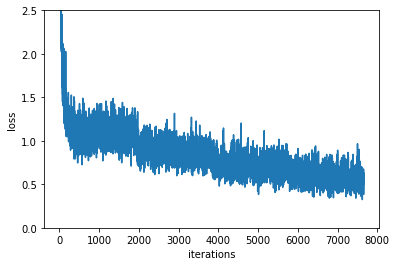

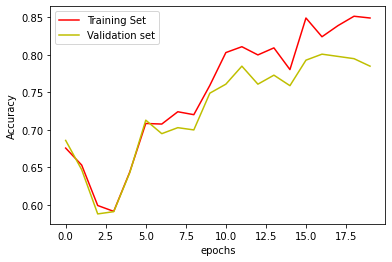

In [ ]:
resnet1 = copy.deepcopy(resnet)
train_vis(resnet1, learning_rate=2.016292e-04, epochs=20, step_decay=5, reg=2e-1)

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128


p1 = 0.2
p2 = 0.3
p3 = 0.4
lr = 2e-3
reg = 4e-05


model_d = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p1),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p2),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p3),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Dropout(p1), nn.Linear(4*4*channel6, 256), nn.ReLU(), nn.Linear(256,10))

In [ ]:
learning_rate = 10**np.random.uniform(-7,-1,10)
for lr in sorted(learning_rate):
  print('Learning Rate : %e' %(lr), end = ' ')
  model = copy.deepcopy(model_d)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=0, verbose=False)

Learning Rate : 3.150178e-07 epoch : 1 loss : 2.3120 Training Accuracy : 8.36 Validation Accuracy : 11.40

Learning Rate : 4.216550e-07 epoch : 1 loss : 2.3322 Training Accuracy : 10.78 Validation Accuracy : 9.90

Learning Rate : 6.287951e-07 epoch : 1 loss : 2.3291 Training Accuracy : 10.39 Validation Accuracy : 11.60

Learning Rate : 3.510787e-06 epoch : 1 loss : 2.2025 Training Accuracy : 21.41 Validation Accuracy : 21.60

Learning Rate : 1.456543e-05 epoch : 1 loss : 1.9114 Training Accuracy : 29.14 Validation Accuracy : 28.70

Learning Rate : 1.580187e-05 epoch : 1 loss : 1.8677 Training Accuracy : 32.73 Validation Accuracy : 29.80

Learning Rate : 8.125630e-05 epoch : 1 loss : 1.6638 Training Accuracy : 28.52 Validation Accuracy : 28.70

Learning Rate : 2.752416e-04 epoch : 1 loss : 1.4719 Training Accuracy : 40.31 Validation Accuracy : 37.80

Learning Rate : 4.161098e-03 epoch : 1 loss : 1.3979 Training Accuracy : 47.58 Validation Accuracy : 51.10

Learning Rate : 3.096470e-02 e

In [ ]:
learning_rate = 10**np.random.uniform(-4,-1,10)
for lr in sorted(learning_rate):
  print('Learning Rate : %e' %(lr), end = ' ')
  model = copy.deepcopy(model_d)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=0, verbose=False)

Learning Rate : 4.275895e-04 epoch : 1 loss : 1.2496 Training Accuracy : 41.41 Validation Accuracy : 41.10

Learning Rate : 4.676564e-04 epoch : 1 loss : 1.2483 Training Accuracy : 48.83 Validation Accuracy : 48.50

Learning Rate : 7.018855e-04 epoch : 1 loss : 1.4724 Training Accuracy : 45.47 Validation Accuracy : 43.70

Learning Rate : 7.950726e-04 epoch : 1 loss : 1.5047 Training Accuracy : 50.16 Validation Accuracy : 50.80

Learning Rate : 2.014501e-03 epoch : 1 loss : 1.4945 Training Accuracy : 53.91 Validation Accuracy : 57.00

Learning Rate : 3.717105e-03 epoch : 1 loss : 1.2827 Training Accuracy : 52.03 Validation Accuracy : 52.50

Learning Rate : 5.642101e-03 epoch : 1 loss : 1.4665 Training Accuracy : 47.89 Validation Accuracy : 48.60

Learning Rate : 6.979911e-03 epoch : 1 loss : 1.5100 Training Accuracy : 45.08 Validation Accuracy : 45.80

Learning Rate : 1.581838e-02 epoch : 1 loss : 2.0070 Training Accuracy : 35.55 Validation Accuracy : 38.50

Learning Rate : 3.498011e-02

epoch : 1 loss : 1.0729 Training Accuracy : 65.47 Validation Accuracy : 66.30

epoch : 2 loss : 0.9892 Training Accuracy : 71.17 Validation Accuracy : 70.10

epoch : 3 loss : 0.7733 Training Accuracy : 71.72 Validation Accuracy : 70.20

epoch : 4 loss : 0.9622 Training Accuracy : 74.77 Validation Accuracy : 71.80

epoch : 5 loss : 0.9142 Training Accuracy : 75.31 Validation Accuracy : 74.70

epoch : 6 loss : 0.8304 Training Accuracy : 77.97 Validation Accuracy : 75.70

epoch : 7 loss : 0.6380 Training Accuracy : 78.36 Validation Accuracy : 77.40

epoch : 8 loss : 0.5395 Training Accuracy : 79.22 Validation Accuracy : 77.20

epoch : 9 loss : 0.6402 Training Accuracy : 80.00 Validation Accuracy : 78.80

epoch : 10 loss : 0.6927 Training Accuracy : 81.64 Validation Accuracy : 80.50

epoch : 11 loss : 0.6686 Training Accuracy : 80.62 Validation Accuracy : 80.70

epoch : 12 loss : 0.6389 Training Accuracy : 81.88 Validation Accuracy : 79.00

epoch : 13 loss : 0.7512 Training Accuracy : 81.9

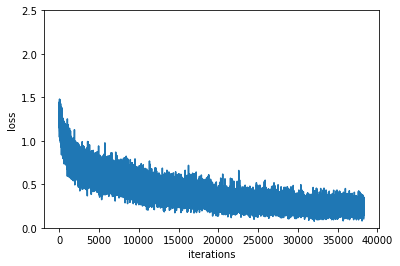

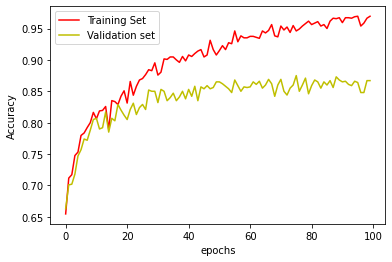

In [ ]:
lr = 2.014501e-03
train_vis(model_d, learning_rate=lr, epochs=100, step_decay=25, reg=4e-5)

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

p1 = 0.2
p2 = 0.3
p3 = 0.4
lr = 2.014501e-03

model_e = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p1),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p2),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p3),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.ReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Dropout(p3), nn.Linear(4*4*channel6, 256), nn.ReLU(), nn.Linear(256,10))

In [ ]:
learning_rate = 10**np.random.uniform(-7,-1,10)
for lr in sorted(learning_rate):
  print('Learning Rate : %e' %(lr), end = ' ')
  model = copy.deepcopy(model_e)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=0, verbose=False)

Learning Rate : 5.491323e-07 epoch : 1 loss : 2.2817 Training Accuracy : 11.33 Validation Accuracy : 10.70

Learning Rate : 6.882382e-07 epoch : 1 loss : 2.3735 Training Accuracy : 10.23 Validation Accuracy : 12.90

Learning Rate : 1.904680e-06 epoch : 1 loss : 2.3244 Training Accuracy : 16.09 Validation Accuracy : 17.60

Learning Rate : 6.370158e-06 epoch : 1 loss : 2.1518 Training Accuracy : 18.20 Validation Accuracy : 17.20

Learning Rate : 1.055325e-05 epoch : 1 loss : 1.9649 Training Accuracy : 17.58 Validation Accuracy : 18.00

Learning Rate : 2.103785e-04 epoch : 1 loss : 1.4172 Training Accuracy : 38.67 Validation Accuracy : 37.10

Learning Rate : 1.322348e-03 epoch : 1 loss : 1.2253 Training Accuracy : 57.81 Validation Accuracy : 54.70

Learning Rate : 6.895460e-03 epoch : 1 loss : 1.5554 Training Accuracy : 44.84 Validation Accuracy : 45.40

Learning Rate : 1.754387e-02 epoch : 1 loss : 1.6422 Training Accuracy : 38.98 Validation Accuracy : 43.30

Learning Rate : 1.941259e-02

In [ ]:
learning_rate = 10**np.random.uniform(-4,-1,10)
for lr in sorted(learning_rate):
  print('Learning Rate : %e' %(lr), end = ' ')
  model = copy.deepcopy(model_e)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=0, verbose=False)

Learning Rate : 4.008889e-04 epoch : 1 loss : 1.4747 Training Accuracy : 46.95 Validation Accuracy : 46.90

Learning Rate : 4.167304e-04 epoch : 1 loss : 1.1983 Training Accuracy : 42.66 Validation Accuracy : 43.50

Learning Rate : 1.613851e-03 epoch : 1 loss : 1.3796 Training Accuracy : 53.59 Validation Accuracy : 54.50

Learning Rate : 1.857461e-03 epoch : 1 loss : 1.3941 Training Accuracy : 57.66 Validation Accuracy : 56.00

Learning Rate : 2.294931e-03 epoch : 1 loss : 1.4009 Training Accuracy : 55.00 Validation Accuracy : 56.90

Learning Rate : 3.919704e-03 epoch : 1 loss : 1.3524 Training Accuracy : 49.14 Validation Accuracy : 51.20

Learning Rate : 4.089254e-03 epoch : 1 loss : 1.3903 Training Accuracy : 44.77 Validation Accuracy : 44.50

Learning Rate : 4.284387e-02 epoch : 1 loss : 2.3056 Training Accuracy : 9.30 Validation Accuracy : 9.80

Learning Rate : 6.327025e-02 epoch : 1 loss : 2.3040 Training Accuracy : 8.12 Validation Accuracy : 7.80

Learning Rate : 8.830944e-02 epo

In [ ]:
lr = 2.294931e-03
regularization = 10**np.random.uniform(-6,-1,10)
for reg in regularization:
  print('Regularization : %e' %(reg), end=' ')
  model = copy.deepcopy(model_e)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=reg, verbose=False)

Regularization : 4.456815e-06 epoch : 1 loss : 1.2443 Training Accuracy : 50.86 Validation Accuracy : 54.60

Regularization : 4.731356e-05 epoch : 1 loss : 1.5079 Training Accuracy : 51.17 Validation Accuracy : 51.50

Regularization : 2.165983e-02 epoch : 1 loss : 1.3932 Training Accuracy : 47.42 Validation Accuracy : 49.00

Regularization : 3.420259e-04 epoch : 1 loss : 1.2508 Training Accuracy : 55.23 Validation Accuracy : 56.10

Regularization : 6.350453e-05 epoch : 1 loss : 1.2931 Training Accuracy : 55.62 Validation Accuracy : 54.90

Regularization : 1.095844e-03 epoch : 1 loss : 1.4083 Training Accuracy : 55.94 Validation Accuracy : 56.90

Regularization : 1.612920e-06 epoch : 1 loss : 1.4469 Training Accuracy : 53.75 Validation Accuracy : 50.90

Regularization : 2.399717e-02 epoch : 1 loss : 1.3798 Training Accuracy : 42.66 Validation Accuracy : 44.20

Regularization : 7.006736e-04 epoch : 1 loss : 1.0836 Training Accuracy : 55.55 Validation Accuracy : 56.90

Regularization : 9.

epoch : 1 loss : 1.1284 Training Accuracy : 58.59 Validation Accuracy : 60.40

epoch : 2 loss : 1.0775 Training Accuracy : 67.50 Validation Accuracy : 67.00

epoch : 3 loss : 0.9312 Training Accuracy : 67.97 Validation Accuracy : 66.20

epoch : 4 loss : 0.8460 Training Accuracy : 70.16 Validation Accuracy : 72.60

epoch : 5 loss : 0.8726 Training Accuracy : 74.84 Validation Accuracy : 72.20

epoch : 6 loss : 0.7165 Training Accuracy : 73.52 Validation Accuracy : 72.80

epoch : 7 loss : 0.8038 Training Accuracy : 70.47 Validation Accuracy : 69.50

epoch : 8 loss : 0.6719 Training Accuracy : 71.48 Validation Accuracy : 73.70

epoch : 9 loss : 0.8832 Training Accuracy : 73.28 Validation Accuracy : 73.30

epoch : 10 loss : 0.7438 Training Accuracy : 72.81 Validation Accuracy : 72.10

epoch : 11 loss : 0.8719 Training Accuracy : 74.84 Validation Accuracy : 74.50

epoch : 12 loss : 0.7229 Training Accuracy : 76.02 Validation Accuracy : 74.30

epoch : 13 loss : 0.9472 Training Accuracy : 75.7

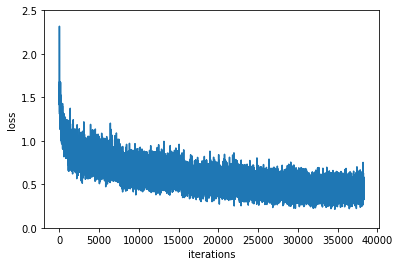

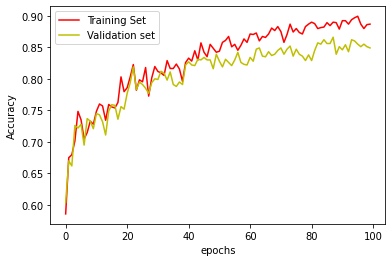

In [ ]:
lr = 2.294931e-03
reg = 1.095844e-03
train_vis(model, learning_rate=lr, epochs=100, step_decay=20, reg=reg, verbose=True)

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

p1 = 0.2
p2 = 0.3
p3 = 0.4

model_f = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p1),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p2),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p3),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Dropout(p1), nn.Linear(4*4*channel6, 256), nn.LeakyReLU(), nn.Linear(256,10))

In [ ]:
learning_rate = 10**np.random.uniform(-4,-1,10)
for lr in sorted(learning_rate):
  print('Learning Rate : %e' %(lr), end = ' ')
  model = copy.deepcopy(model_f)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=0, verbose=False)

Learning Rate : 1.059743e-04 epoch : 1 loss : 1.7405 Training Accuracy : 36.33 Validation Accuracy : 36.00

Learning Rate : 5.464211e-04 epoch : 1 loss : 1.2037 Training Accuracy : 48.36 Validation Accuracy : 48.50

Learning Rate : 3.204739e-03 epoch : 1 loss : 1.5079 Training Accuracy : 49.77 Validation Accuracy : 49.80

Learning Rate : 3.694500e-03 epoch : 1 loss : 1.3985 Training Accuracy : 53.20 Validation Accuracy : 52.40

Learning Rate : 7.966315e-03 epoch : 1 loss : 1.6467 Training Accuracy : 41.56 Validation Accuracy : 43.90

Learning Rate : 1.221615e-02 epoch : 1 loss : 1.4669 Training Accuracy : 44.14 Validation Accuracy : 45.90

Learning Rate : 1.571284e-02 epoch : 1 loss : 1.6094 Training Accuracy : 46.17 Validation Accuracy : 43.20

Learning Rate : 3.084701e-02 epoch : 1 loss : 1.9577 Training Accuracy : 32.97 Validation Accuracy : 35.30

Learning Rate : 6.634168e-02 epoch : 1 loss : 1.8517 Training Accuracy : 27.81 Validation Accuracy : 30.00

Learning Rate : 8.625383e-02

In [ ]:
learning_rate = 10**np.random.uniform(-3.5,-2.5,10)
for lr in sorted(learning_rate):
  print('Learning Rate : %e' %(lr), end = ' ')
  model = copy.deepcopy(model_f)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=0, verbose=False)

Learning Rate : 3.833033e-04 epoch : 1 loss : 1.4074 Training Accuracy : 49.77 Validation Accuracy : 48.60

Learning Rate : 4.712565e-04 epoch : 1 loss : 1.3213 Training Accuracy : 46.72 Validation Accuracy : 46.30

Learning Rate : 5.177551e-04 epoch : 1 loss : 1.3764 Training Accuracy : 49.45 Validation Accuracy : 45.70

Learning Rate : 6.150844e-04 epoch : 1 loss : 1.4254 Training Accuracy : 56.64 Validation Accuracy : 54.20

Learning Rate : 7.151532e-04 epoch : 1 loss : 1.2896 Training Accuracy : 50.78 Validation Accuracy : 53.20

Learning Rate : 9.860913e-04 epoch : 1 loss : 1.2560 Training Accuracy : 49.53 Validation Accuracy : 50.90

Learning Rate : 1.107591e-03 epoch : 1 loss : 1.1187 Training Accuracy : 52.58 Validation Accuracy : 54.80

Learning Rate : 1.445868e-03 epoch : 1 loss : 1.1151 Training Accuracy : 56.33 Validation Accuracy : 57.70

Learning Rate : 2.179405e-03 epoch : 1 loss : 1.2438 Training Accuracy : 53.67 Validation Accuracy : 54.40

Learning Rate : 2.691027e-03

In [ ]:
lr = 1.445868e-03
regularization = 10**np.random.uniform(-6,-1,10)
for reg in regularization:
  print('Regularization : %e' %(reg), end=' ')
  model = copy.deepcopy(model_f)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=reg, verbose=False)

Regularization : 9.349300e-04 epoch : 1 loss : 1.4361 Training Accuracy : 54.45 Validation Accuracy : 54.40

Regularization : 1.148202e-05 epoch : 1 loss : 1.1017 Training Accuracy : 56.33 Validation Accuracy : 57.50

Regularization : 9.905830e-06 epoch : 1 loss : 1.1269 Training Accuracy : 55.86 Validation Accuracy : 58.60

Regularization : 9.382897e-02 epoch : 1 loss : 1.4378 Training Accuracy : 46.25 Validation Accuracy : 45.70

Regularization : 1.273404e-04 epoch : 1 loss : 1.4046 Training Accuracy : 54.53 Validation Accuracy : 55.50

Regularization : 9.947950e-04 epoch : 1 loss : 1.0513 Training Accuracy : 54.22 Validation Accuracy : 54.90

Regularization : 2.591414e-02 epoch : 1 loss : 1.2906 Training Accuracy : 50.31 Validation Accuracy : 52.10

Regularization : 7.209851e-04 epoch : 1 loss : 1.0921 Training Accuracy : 55.39 Validation Accuracy : 55.00

Regularization : 3.765830e-04 epoch : 1 loss : 1.2610 Training Accuracy : 55.70 Validation Accuracy : 56.10

Regularization : 4.

In [ ]:
lr = 1.445868e-03
regularization = 10**np.random.uniform(-4.5,-3,10)
for reg in regularization:
  print('Regularization : %e' %(reg), end=' ')
  model = copy.deepcopy(model_f)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=reg, verbose=False)

  # Regularization : 3.500942e-05 epoch : 1 loss : 1.3421 Training Accuracy : 57.42 Validation Accuracy : 59.10

Regularization : 6.426271e-05 epoch : 1 loss : 1.2779 Training Accuracy : 50.86 Validation Accuracy : 51.00

Regularization : 7.214335e-04 epoch : 1 loss : 1.1966 Training Accuracy : 49.77 Validation Accuracy : 53.60

Regularization : 5.782184e-05 epoch : 1 loss : 1.4421 Training Accuracy : 56.33 Validation Accuracy : 52.00

Regularization : 3.173622e-04 epoch : 1 loss : 1.1549 Training Accuracy : 56.88 Validation Accuracy : 57.00

Regularization : 3.303844e-05 epoch : 1 loss : 1.3051 Training Accuracy : 58.75 Validation Accuracy : 57.70

Regularization : 2.429476e-04 epoch : 1 loss : 1.1754 Training Accuracy : 54.84 Validation Accuracy : 55.80

Regularization : 6.345271e-04 epoch : 1 loss : 1.1696 Training Accuracy : 55.94 Validation Accuracy : 55.80

Regularization : 2.494548e-04 epoch : 1 loss : 1.3150 Training Accuracy : 53.28 Validation Accuracy : 55.20

Regularization : 2.096367e-04 epoch : 1 loss : 1.0768 Training Accuracy : 57.58 Validation Accuracy : 56.10

Regularization : 3.

In [ ]:
lr = 1.445868e-03
regularization = 10**np.random.uniform(-4,-3,10)
for reg in regularization:
  print('Regularization : %e' %(reg), end=' ')
  model = copy.deepcopy(model_f)
  train_vis(model, learning_rate=lr, epochs=1, step_decay=1, reg=reg, verbose=False)

Regularization : 5.357581e-04 epoch : 1 loss : 1.3710 Training Accuracy : 53.67 Validation Accuracy : 57.10

Regularization : 5.912072e-04 epoch : 1 loss : 1.2337 Training Accuracy : 55.31 Validation Accuracy : 56.80

Regularization : 4.328422e-04 epoch : 1 loss : 1.1969 Training Accuracy : 57.27 Validation Accuracy : 55.10

Regularization : 4.541989e-04 epoch : 1 loss : 1.1846 Training Accuracy : 55.31 Validation Accuracy : 53.00

Regularization : 3.052641e-04 epoch : 1 loss : 1.3290 Training Accuracy : 56.02 Validation Accuracy : 54.10

Regularization : 1.661135e-04 epoch : 1 loss : 1.4417 Training Accuracy : 54.53 Validation Accuracy : 54.70

Regularization : 4.056472e-04 epoch : 1 loss : 1.2060 Training Accuracy : 52.11 Validation Accuracy : 53.60

Regularization : 2.735633e-04 epoch : 1 loss : 1.1942 Training Accuracy : 56.17 Validation Accuracy : 55.70

Regularization : 2.476569e-04 epoch : 1 loss : 1.1811 Training Accuracy : 54.06 Validation Accuracy : 57.20

Regularization : 1.

In [ ]:
model_save_name = 'model_d(86.7)'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model_d.state_dict(), path)

model_save_name = 'model_e(84.9)'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model_e.state_dict(), path)

# model_save_name = 'classifier.pt'
# path = F"/content/gdrive/My Drive/{model_save_name}"
# model.load_state_dict(torch.load(path))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


epoch : 1 loss : 1.2866 Training Accuracy : 56.88 Validation Accuracy : 56.00

epoch : 2 loss : 0.8721 Training Accuracy : 64.06 Validation Accuracy : 64.40

epoch : 3 loss : 1.2329 Training Accuracy : 70.39 Validation Accuracy : 67.10

epoch : 4 loss : 0.7700 Training Accuracy : 72.58 Validation Accuracy : 72.60

epoch : 5 loss : 0.8800 Training Accuracy : 77.19 Validation Accuracy : 71.00

epoch : 6 loss : 0.6653 Training Accuracy : 78.75 Validation Accuracy : 76.20

epoch : 7 loss : 0.7393 Training Accuracy : 76.48 Validation Accuracy : 76.30

epoch : 8 loss : 0.7205 Training Accuracy : 79.06 Validation Accuracy : 77.00

epoch : 9 loss : 0.6627 Training Accuracy : 81.09 Validation Accuracy : 77.60

epoch : 10 loss : 0.7011 Training Accuracy : 78.52 Validation Accuracy : 77.20

epoch : 11 loss : 0.6755 Training Accuracy : 80.47 Validation Accuracy : 76.30

epoch : 12 loss : 0.7120 Training Accuracy : 80.78 Validation Accuracy : 77.90

epoch : 13 loss : 0.7140 Training Accuracy : 80.8

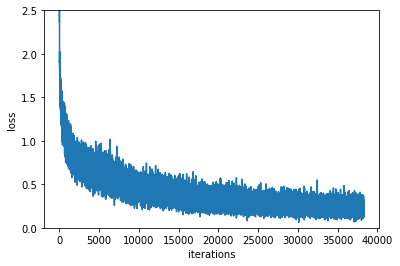

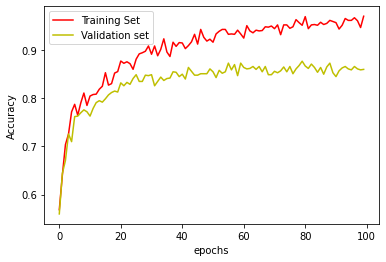

In [ ]:
lr = 1.445868e-03
reg = 3.500942e-05
train_vis(model_f, learning_rate=lr, epochs=100, step_decay=20, reg=reg, verbose=True)

In [ ]:
model_save_name = 'model_f(84.9)'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model_f.state_dict(), path)

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

dropout_param = 10**np.random.uniform(-1,0,10)
lr = 1.445868e-03
reg = 4e-05
for p in dropout_param:
  print('Dropout Probability :%0.4f' %(p), end=' ')
  model_g = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Dropout(p), nn.Linear(4*4*channel6, 256), nn.LeakyReLU(), nn.Linear(256,10))
  train_vis(model_g, learning_rate=lr, epochs=10, step_decay=1, reg=reg, verbose=False)

Dropout Probability :0.3148 epoch : 1 loss : 1.1896 Training Accuracy : 53.91 Validation Accuracy : 55.30

epoch : 2 loss : 1.0670 Training Accuracy : 62.42 Validation Accuracy : 62.70

epoch : 3 loss : 0.9422 Training Accuracy : 67.03 Validation Accuracy : 65.60

epoch : 4 loss : 0.9298 Training Accuracy : 70.16 Validation Accuracy : 69.10

epoch : 5 loss : 0.8629 Training Accuracy : 69.61 Validation Accuracy : 71.00

epoch : 6 loss : 0.8588 Training Accuracy : 71.64 Validation Accuracy : 71.90

epoch : 7 loss : 0.9163 Training Accuracy : 71.17 Validation Accuracy : 70.20

epoch : 8 loss : 0.7616 Training Accuracy : 69.61 Validation Accuracy : 71.10

epoch : 9 loss : 0.9254 Training Accuracy : 71.17 Validation Accuracy : 70.20

epoch : 10 loss : 0.7808 Training Accuracy : 72.66 Validation Accuracy : 71.30

Dropout Probability :0.2775 epoch : 1 loss : 1.2642 Training Accuracy : 53.28 Validation Accuracy : 55.10

epoch : 2 loss : 1.1061 Training Accuracy : 66.56 Validation Accuracy : 66

KeyboardInterrupt: ignored

epoch : 1 loss : 1.4963 Training Accuracy : 41.95 Validation Accuracy : 42.60

epoch : 2 loss : 1.3318 Training Accuracy : 48.75 Validation Accuracy : 50.40

epoch : 3 loss : 1.1772 Training Accuracy : 58.44 Validation Accuracy : 59.70

epoch : 4 loss : 1.3901 Training Accuracy : 62.11 Validation Accuracy : 62.80

epoch : 5 loss : 1.0562 Training Accuracy : 65.31 Validation Accuracy : 63.30

epoch : 6 loss : 0.9100 Training Accuracy : 65.78 Validation Accuracy : 63.20

epoch : 7 loss : 0.9346 Training Accuracy : 69.30 Validation Accuracy : 66.20

epoch : 8 loss : 0.7401 Training Accuracy : 67.19 Validation Accuracy : 67.70

epoch : 9 loss : 0.8640 Training Accuracy : 67.19 Validation Accuracy : 67.70

epoch : 10 loss : 1.1848 Training Accuracy : 68.59 Validation Accuracy : 69.70

epoch : 11 loss : 0.9812 Training Accuracy : 73.28 Validation Accuracy : 69.10

epoch : 12 loss : 0.9769 Training Accuracy : 69.61 Validation Accuracy : 67.70

epoch : 13 loss : 0.8322 Training Accuracy : 73.2

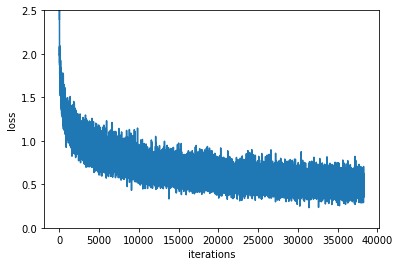

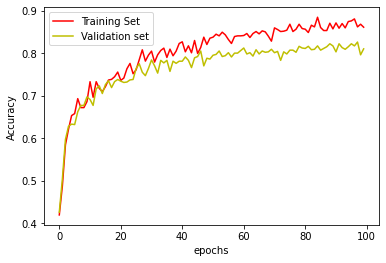

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

p = 0.3
model_g = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p),
                      nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p),
                      nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                      nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p),
                      nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                      Flatten(), nn.Dropout(p), nn.Linear(4*4*channel6, 256), nn.LeakyReLU(), nn.Linear(256,10))
train_vis(model_g, learning_rate=1.445868e-03, epochs=100, step_decay=25, reg=4e-5)

In [ ]:
train_vis(model_g, learning_rate=(1.445868e-03/32), epochs=100, step_decay=25, reg=(100*4e-5))

epoch : 1 loss : 0.4411 Training Accuracy : 86.88 Validation Accuracy : 82.00

epoch : 2 loss : 0.6279 Training Accuracy : 86.41 Validation Accuracy : 83.10

epoch : 3 loss : 0.4304 Training Accuracy : 86.48 Validation Accuracy : 80.00

epoch : 4 loss : 0.5675 Training Accuracy : 85.86 Validation Accuracy : 81.10

epoch : 5 loss : 0.4491 Training Accuracy : 85.70 Validation Accuracy : 81.90

epoch : 6 loss : 0.5056 Training Accuracy : 87.27 Validation Accuracy : 80.80

epoch : 7 loss : 0.5336 Training Accuracy : 86.33 Validation Accuracy : 82.90

epoch : 8 loss : 0.4786 Training Accuracy : 86.17 Validation Accuracy : 81.50



In [ ]:
model_save_name = 'model_g(87)'
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model_f.state_dict(), path)

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

dropout_probs = np.random.uniform(0.01, 0.99, 10)

for p in dropout_probs:
  model = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p),
                        nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                        nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p),
                        nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                        nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p),
                        nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                        Flatten(), nn.Dropout(p), nn.Linear(4*4*channel6, 256), nn.LeakyReLU(), nn.Linear(256,10))
  model_save_name = 'model_g(87)'
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  model.load_state_dict(torch.load(path))
  print('Dropout Probability :%0.2f' %(p), end=' ')
  val_acc, train_acc = check(loader_val, model), check(loader_train, model)
  print('Train : %0.2f Val Acc : %0.2f' %(100*train_acc, 100*val_acc), end = ' ')
  train_vis(model, learning_rate=1e-5, verbose=False)

Dropout Probability :0.97 Train : 95.23 Val Acc : 86.40 epoch : 1 loss : 20.4807 Training Accuracy : 14.30 Validation Accuracy : 14.90

Dropout Probability :0.15 Train : 95.78 Val Acc : 86.50 epoch : 1 loss : 0.1420 Training Accuracy : 97.34 Validation Accuracy : 85.90

Dropout Probability :0.55 Train : 95.78 Val Acc : 84.60 epoch : 1 loss : 0.7167 Training Accuracy : 91.09 Validation Accuracy : 83.00

Dropout Probability :0.19 Train : 96.25 Val Acc : 86.40 epoch : 1 loss : 0.1544 Training Accuracy : 96.80 Validation Accuracy : 87.30

Dropout Probability :0.41 Train : 96.25 Val Acc : 86.70 epoch : 1 loss : 0.3360 Training Accuracy : 95.23 Validation Accuracy : 86.90

Dropout Probability :0.48 Train : 95.16 Val Acc : 86.90 epoch : 1 loss : 0.6573 Training Accuracy : 92.58 Validation Accuracy : 84.50

Dropout Probability :0.11 Train : 95.31 Val Acc : 85.30 epoch : 1 loss : 0.0967 Training Accuracy : 96.88 Validation Accuracy : 87.20

Dropout Probability :0.34 Train : 95.94 Val Acc : 85.4

In [ ]:
channel1 = 16
channel2 = 16
channel3 = 32
channel4 = 64
channel5 = 64
channel6 = 128

dropout_probs = np.random.uniform(0.01, 0.99, 10)

for p in dropout_probs:
  model = nn.Sequential(nn.Conv2d(3, channel1, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel1), nn.Dropout(p),
                        nn.Conv2d(channel1, channel2, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel2), nn.MaxPool2d(2,2),
                        nn.Conv2d(channel2, channel3, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel3), nn.Dropout(p),
                        nn.Conv2d(channel3, channel4, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel4), nn.MaxPool2d(2,2),
                        nn.Conv2d(channel4, channel5, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel5), nn.Dropout(p),
                        nn.Conv2d(channel5, channel6, (3,3), stride=1, padding=1), nn.LeakyReLU(), nn.BatchNorm2d(channel6), nn.MaxPool2d(2,2),
                        Flatten(), nn.Dropout(p), nn.Linear(4*4*channel6, 256), nn.LeakyReLU(), nn.Linear(256,10))
  model_save_name = 'model_g(87)'
  path = F"/content/gdrive/My Drive/{model_save_name}" 
  model.load_state_dict(torch.load(path))
  print('Dropout Probability :%0.2f' %(p), end=' ')
  val_acc, train_acc = check(loader_val, model), check(loader_train, model)
  print('Train : %0.2f Val Acc : %0.2f' %(100*train_acc, 100*val_acc), end = ' ')
  train_vis(model, learning_rate=1e-5, verbose=False)
# learning_rate=10**np.random.uniform(-10,-2,10)
# for lr in learning_rate:
#   model_save_name = 'model_g(87)'
#   path = F"/content/gdrive/My Drive/{model_save_name}" 
#   model.load_state_dict(torch.load(path))
#   val_acc, train_acc = check(loader_val, model), check(loader_train, model)
#   print('Train : %0.2f Val Acc : %0.2f' %(100*train_acc, 100*val_acc), end=' ')
#   print('Learning Rate : %e' %(lr), end=' ')
#   train_vis(model,  learning_rate=lr, verbose=False)

Dropout Probability :0.22 Train : 65.08 Val Acc : 58.40 

KeyboardInterrupt: ignored

Learning Rate : 1.989039e-06 epoch : 1 loss : 0.1921 Training Accuracy : 96.56 Validation Accuracy : 86.10

Learning Rate : 2.161253e-05 epoch : 1 loss : 0.2791 Training Accuracy : 95.55 Validation Accuracy : 87.20

Learning Rate : 9.974657e-08 epoch : 1 loss : 0.1748 Training Accuracy : 95.86 Validation Accuracy : 84.90

Learning Rate : 1.396382e-10 